# 📊 Notebook 5: Interactive Visualizations

## 1. Setup

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pavannn16/CS5660-BERTopic-arXiv/blob/main/notebooks/05_visualization.ipynb)

---

**Purpose:** Generate interactive topic visualizations and word clouds.

**Time:** ~2 minutes

In [1]:
# Install required packages
%pip install bertopic plotly pandas numpy wordcloud matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 6.7 MB/s eta 0:00:00


In [ ]:
# ============================================================
# PROJECT PATH SETUP - Works on Colab Web, VS Code, or Local
# ============================================================

import os
from pathlib import Path

# Detect environment and set project path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_PATH = '/content/drive/MyDrive/CS5660_BERTopic_arXiv'
    print("✅ Running on Google Colab")
else:
    PROJECT_PATH = str(Path(os.getcwd()).parent) if 'notebooks' in os.getcwd() else os.getcwd()
    print("✅ Running locally")

print(f"📁 Project path: {PROJECT_PATH}")

Project path: /content
Path exists: True


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import json
from collections import Counter

# BERTopic
from bertopic import BERTopic

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'notebook'  # Works in VS Code

import matplotlib.pyplot as plt
from wordcloud import WordCloud

print("Libraries imported!")

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


KeyboardInterrupt: 

## 2. Load Data

In [ ]:
# Load BERTopic model
model_path = f"{PROJECT_PATH}/models/bertopic_model"
topic_model = BERTopic.load(model_path)
print("Model loaded!")

# Load data with topic assignments
df = pd.read_csv(f"{PROJECT_PATH}/results/topic_assignments.csv")
documents = df['text'].tolist()
topics = df['topic'].tolist()

print(f"Loaded {len(df)} documents")
print(f"Topics: {len(set(topics)) - 1} (excluding outliers)")

# Load 2D embeddings
embeddings_2d = np.load(f"{PROJECT_PATH}/data/embeddings/embeddings_2d.npy")
print(f"2D embeddings shape: {embeddings_2d.shape}")

# Get topic info
topic_info = topic_model.get_topic_info()
topic_info.head()

2025-12-02 04:12:06,402 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


Model loaded!
Loaded 19898 documents
Topics: 159 (excluding outliers)
2D embeddings shape: (19898, 2)


Topic  Count                                     Name  \
0     -1   5146        -1_language_llms_reasoning_agents   
1      0    796  0_segmentation_medical_clinical_imaging   
2      1    578       1_diffusion_image_generation_video   
3      2    539     2_reasoning_rlvr_reasoning models_rl   
4      3    468          3_rag_retrieval_knowledge_graph   

                                      Representation  Representative_Docs  
0  [language, llms, reasoning, agents, ai, langua...                  NaN  
1  [segmentation, medical, clinical, imaging, ima...                  NaN  
2  [diffusion, image, generation, video, diffusio...                  NaN  
3  [reasoning, rlvr, reasoning models, rl, cot, e...                  NaN  
4  [rag, retrieval, knowledge, graph, retrievalau...                  NaN

## 3. Interactive 2D Topic Map

In [ ]:
# Create visualization dataframe
vis_df = df.copy()
vis_df['x'] = embeddings_2d[:, 0]
vis_df['y'] = embeddings_2d[:, 1]
vis_df['topic_str'] = vis_df['topic'].astype(str)

# Create topic labels
topic_labels = topic_info.set_index('Topic')['Name'].to_dict()
vis_df['topic_label'] = vis_df['topic'].map(topic_labels)

# Separate outliers
vis_df_topics = vis_df[vis_df['topic'] != -1]
vis_df_outliers = vis_df[vis_df['topic'] == -1]

print(f"Documents with topics: {len(vis_df_topics)}")
print(f"Outliers: {len(vis_df_outliers)}")

Documents with topics: 14752
Outliers: 5146


In [ ]:
# Interactive scatter plot with topic colors
fig = px.scatter(
    vis_df_topics,
    x='x', y='y',
    color='topic_str',
    hover_data={'title': True, 'date': True, 'topic_label': True, 'x': False, 'y': False, 'topic_str': False},
    title='arXiv cs.AI Topics - Interactive 2D Map',
    labels={'topic_str': 'Topic'},
    width=1100,
    height=800
)

fig.update_traces(marker=dict(size=6, opacity=0.7))
fig.update_layout(
    legend=dict(title='Topic', itemsizing='constant'),
    xaxis_title='UMAP Dimension 1',
    yaxis_title='UMAP Dimension 2'
)

fig.show()

# Save
fig.write_html(f"{PROJECT_PATH}/results/interactive_topic_map.html")
print(f"\nSaved to {PROJECT_PATH}/results/interactive_topic_map.html")


Saved to /content/results/interactive_topic_map.html


## 4. Topic Bar Charts (Top Words)

In [ ]:
# BERTopic built-in bar chart
fig = topic_model.visualize_barchart(top_n_topics=15, n_words=10)
fig.update_layout(title='Top 15 Topics - Key Words')
fig.show()

fig.write_html(f"{PROJECT_PATH}/results/topic_keywords_barchart.html")

## 5. Topic Similarity Heatmap

In [ ]:
# Topic similarity heatmap
fig = topic_model.visualize_heatmap(top_n_topics=25, n_clusters=5)
fig.update_layout(title='Topic Similarity Matrix')
fig.show()

fig.write_html(f"{PROJECT_PATH}/results/topic_similarity_heatmap.html")

## 6. Topic Hierarchy (Dendrogram)

In [ ]:
# Topic hierarchy
fig = topic_model.visualize_hierarchy(top_n_topics=30)
fig.update_layout(title='Topic Hierarchy - Dendrogram')
fig.show()

fig.write_html(f"{PROJECT_PATH}/results/topic_hierarchy.html")

## 7. Topics Over Time

In [ ]:
# Convert dates
df['date'] = pd.to_datetime(df['date'])

# Topics over time (by month)
topics_over_time = topic_model.topics_over_time(
    documents,
    df['date'].tolist(),
    nr_bins=20
)

# Visualize
fig = topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
fig.update_layout(title='Topic Trends Over Time')
fig.show()

fig.write_html(f"{PROJECT_PATH}/results/topics_over_time.html")

20it [00:32,  1.60s/it]


## 8. Word Clouds per Topic

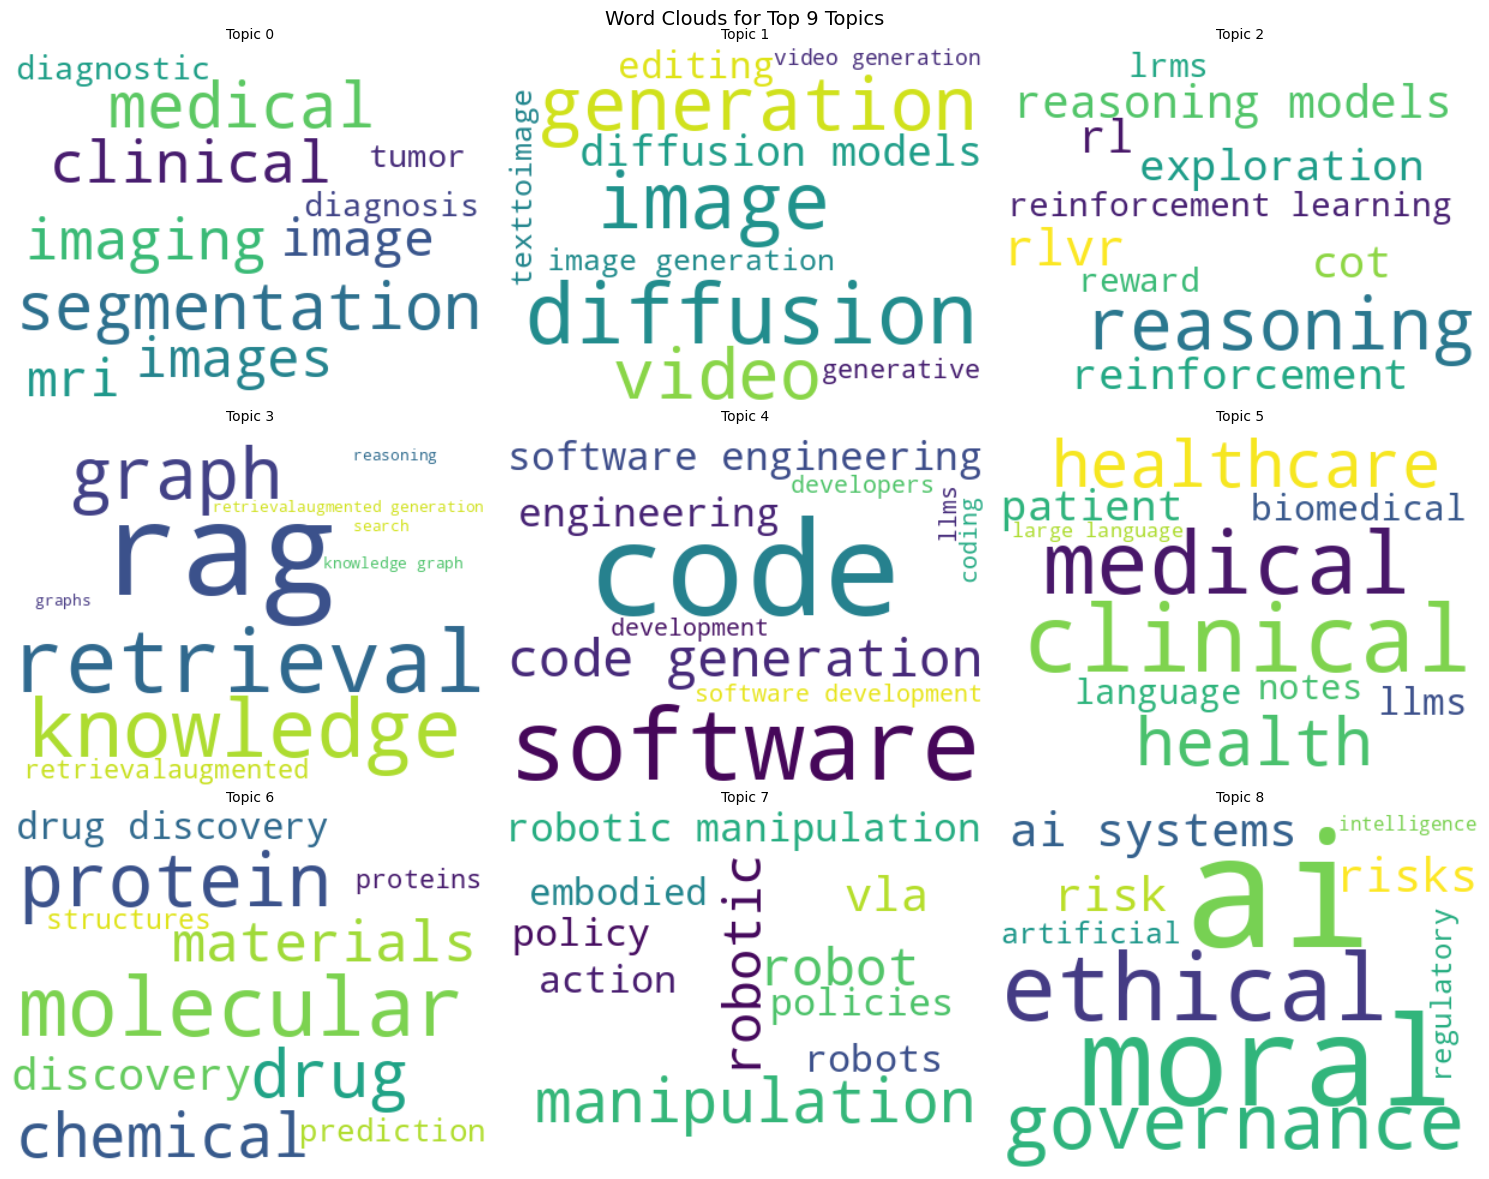

In [ ]:
def create_topic_wordcloud(topic_model, topic_id, max_words=50):
    """Create word cloud for a specific topic."""
    words = topic_model.get_topic(topic_id)
    if not words:
        return None
    
    # Convert to dictionary with weights
    word_freq = {word: abs(weight) for word, weight in words[:max_words]}
    
    # Generate word cloud
    wc = WordCloud(
        width=400, height=300,
        background_color='white',
        colormap='viridis',
        max_words=max_words
    ).generate_from_frequencies(word_freq)
    
    return wc

# Create word clouds for top 9 topics
top_topics = topic_info[topic_info['Topic'] != -1]['Topic'].head(9).tolist()

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, topic_id in enumerate(top_topics):
    wc = create_topic_wordcloud(topic_model, topic_id)
    if wc:
        axes[idx].imshow(wc, interpolation='bilinear')
        topic_name = topic_info[topic_info['Topic'] == topic_id]['Name'].values[0]
        axes[idx].set_title(f"Topic {topic_id}", fontsize=10)
        axes[idx].axis('off')

plt.suptitle('Word Clouds for Top 9 Topics', fontsize=14)
plt.tight_layout()
plt.savefig(f"{PROJECT_PATH}/results/topic_wordclouds.png", dpi=150, bbox_inches='tight')
plt.show()

## 9. Topic Explorer

In [ ]:
def explore_topic(topic_id):
    """Display detailed information about a topic."""
    print(f"\n{'='*60}")
    print(f"TOPIC {topic_id}")
    print(f"{'='*60}")
    
    # Topic info
    info = topic_info[topic_info['Topic'] == topic_id].iloc[0]
    print(f"\nName: {info['Name']}")
    print(f"Documents: {info['Count']}")
    
    # Top words
    words = topic_model.get_topic(topic_id)
    print(f"\nTop 10 Words:")
    for word, score in words[:10]:
        print(f"  • {word}: {score:.4f}")
    
    # Representative documents
    print(f"\nRepresentative Papers:")
    topic_docs = df[df['topic'] == topic_id].head(5)
    for i, row in topic_docs.iterrows():
        print(f"\n  [{row['date']}] {row['title'][:80]}...")
        print(f"    {row['abstract'][:150]}...")

# Explore top 5 topics
for topic_id in topic_info[topic_info['Topic'] != -1]['Topic'].head(5).tolist():
    explore_topic(topic_id)


TOPIC 0

Name: 0_segmentation_medical_clinical_imaging
Documents: 796

Top 10 Words:
  • segmentation: 0.0183
  • medical: 0.0175
  • clinical: 0.0147
  • imaging: 0.0141
  • images: 0.0126
  • image: 0.0111
  • mri: 0.0109
  • diagnostic: 0.0088
  • diagnosis: 0.0087
  • tumor: 0.0086

Representative Papers:

  [2025-11-30 00:00:00] Med-CRAFT: Automated Construction of Interpretable and Multi-Hop Video Workloads...
    The scarcity of high-quality, logically annotated video datasets remains a primary bottleneck in advancing Multi-Modal Large Language Models (MLLMs) f...

  [2025-11-30 00:00:00] TAP-CT: 3D Task-Agnostic Pretraining of Computed Tomography Foundation Models...
    Existing foundation models (FMs) in the medical domain often require extensive fine-tuning or rely on training resource-intensive decoders, while many...

  [2025-11-30 00:00:00] Med-CMR: A Fine-Grained Benchmark Integrating Visual Evidence and Clinical Logic...
    MLLMs MLLMs are beginning to appear in clini

## 10. Topic Size Over Time

In [ ]:
# Group by month and topic
df['year_month'] = df['date'].dt.to_period('M').astype(str)

# Get top 10 topics by size
top_10_topics = topic_info[topic_info['Topic'] != -1]['Topic'].head(10).tolist()

# Filter and count
monthly_counts = df[df['topic'].isin(top_10_topics)].groupby(['year_month', 'topic']).size().reset_index(name='count')

# Add topic names
monthly_counts['topic_name'] = monthly_counts['topic'].map(topic_labels)

# Plot
fig = px.line(
    monthly_counts,
    x='year_month',
    y='count',
    color='topic_name',
    title='Top 10 Topics Over Time (Monthly)',
    labels={'year_month': 'Month', 'count': 'Number of Papers', 'topic_name': 'Topic'},
    width=1000,
    height=500
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

fig.write_html(f"{PROJECT_PATH}/results/topic_monthly_trends.html")

## 11. Topic Distribution Summary

In [ ]:
# Topic distribution pie chart
topic_counts = df[df['topic'] != -1]['topic'].value_counts().head(15)
topic_names = [topic_labels.get(t, f"Topic {t}") for t in topic_counts.index]

fig = go.Figure(data=[go.Pie(
    labels=topic_names,
    values=topic_counts.values,
    hole=0.3,
    textposition='outside'
)])

fig.update_layout(
    title='Topic Distribution (Top 15 Topics)',
    width=800,
    height=600
)

fig.show()
fig.write_html(f"{PROJECT_PATH}/results/topic_distribution_pie.html")

## 12. Export Summary Dashboard

In [ ]:
# Create summary statistics
summary_stats = {
    'Total Documents': len(df),
    'Documents with Topics': len(df[df['topic'] != -1]),
    'Outliers': len(df[df['topic'] == -1]),
    'Number of Topics': len(topic_info) - 1,
    'Date Range': f"{df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}",
    'Largest Topic': topic_info[topic_info['Topic'] != -1].iloc[0]['Name'],
    'Largest Topic Size': topic_info[topic_info['Topic'] != -1].iloc[0]['Count']
}

print("="*60)
print("VISUALIZATION SUMMARY")
print("="*60)
for key, value in summary_stats.items():
    print(f"{key}: {value}")

print("\nGenerated Visualizations:")
visualizations = [
    'interactive_topic_map.html',
    'topic_keywords_barchart.html',
    'topic_similarity_heatmap.html',
    'topic_hierarchy.html',
    'topics_over_time.html',
    'topic_wordclouds.png',
    'topic_monthly_trends.html',
    'topic_distribution_pie.html'
]

for viz in visualizations:
    print(f"  ✓ {viz}")

VISUALIZATION SUMMARY
Total Documents: 19898
Documents with Topics: 14752
Outliers: 5146
Number of Topics: 159
Date Range: 2025-07-01 to 2025-12-01
Largest Topic: 0_segmentation_medical_clinical_imaging
Largest Topic Size: 796

Generated Visualizations:
  ✓ interactive_topic_map.html
  ✓ topic_keywords_barchart.html
  ✓ topic_similarity_heatmap.html
  ✓ topic_hierarchy.html
  ✓ topics_over_time.html
  ✓ topic_wordclouds.png
  ✓ topic_monthly_trends.html
  ✓ topic_distribution_pie.html


## Summary

This notebook has created:
1. ✅ Interactive 2D topic map (UMAP scatter)
2. ✅ Topic keywords bar chart
3. ✅ Topic similarity heatmap
4. ✅ Topic hierarchy dendrogram
5. ✅ Topics over time analysis
6. ✅ Word clouds per topic
7. ✅ Topic explorer function
8. ✅ Monthly topic trends
9. ✅ Topic distribution pie chart

All visualizations are saved as interactive HTML files in the `results/` folder.

**Project Complete!** 

Next steps:
- Review visualizations and results
- Write final report (PDF)
- Package code for submission